# 1 - Discrete

## 1.1 - All error diagrams

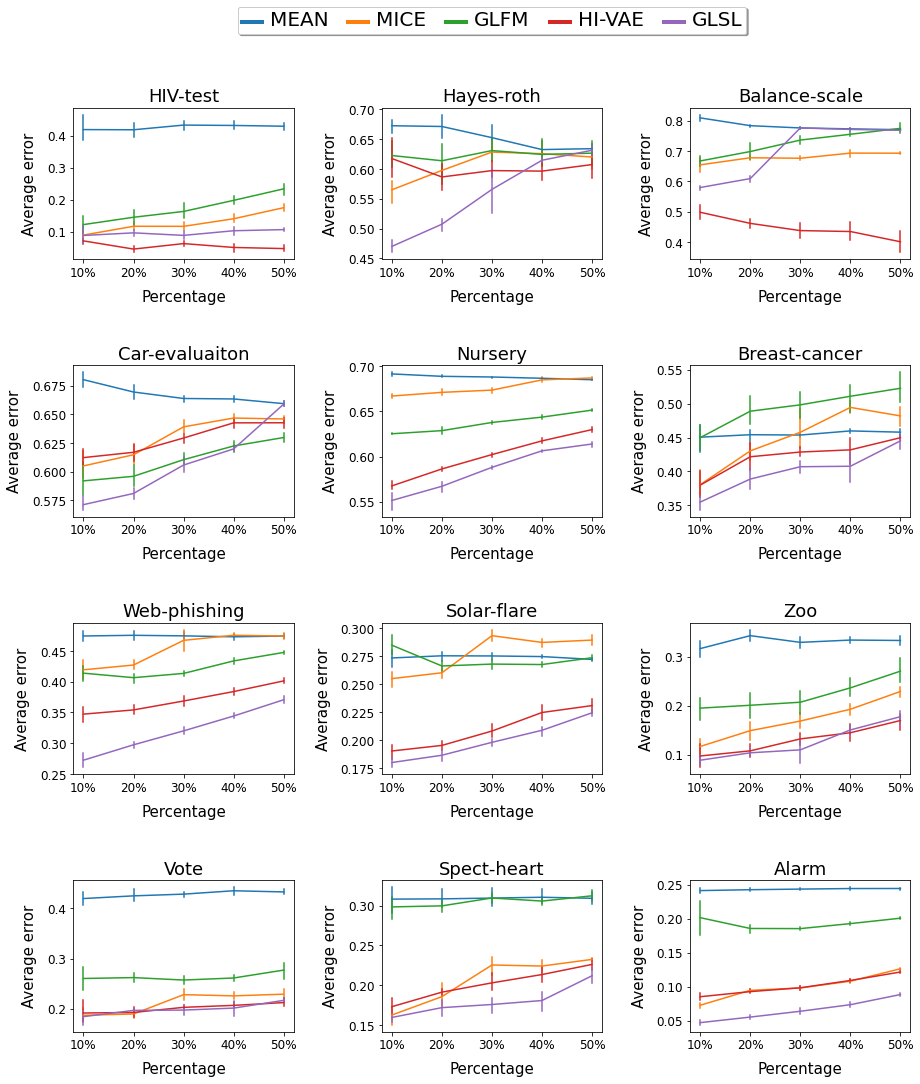

In [16]:
import pandas as pd
import json
import statistics as stats
from os import listdir
import numpy as np

methods = [
    "MEAN", 
    "MICE", 
    "GLFM", 
    "HIVAE", 
    "VBSEM",
    "glsl_EMPTY"
]

renamed_methods = [
    "MEAN", 
    "MICE", 
    "GLFM", 
    "HI-VAE", 
    "GLSL"
]

max_percentage = 6
n_runs = 5
directory = "../../missing_results/discrete/"
data_names = [
        "hiv_test", 
        "hayes_roth",
        "balance_scale", 
        "car_evaluation",
        "nursery", 
        "breast_cancer", 
        "web_phishing",
        "solar_flare",
        "zoo",
        "vote", 
        "spect_heart",
        "alarm"
]

data_names_fancy = ["HIV-test", "Hayes-roth", "Balance-scale", "Car-evaluaiton", "Nursery", "Breast-cancer", 
                    "Web-phishing", "Solar-flare", "Zoo", "Vote", "Spect-heart", "Alarm"]



row_count = 0 # Counts for plotting (row axis)
col_count = 0 # Counts for plotting (col axis)

from matplotlib import pyplot as plt
import seaborn as sns

fig, axs = plt.subplots(4, 3, figsize=(15,17))

for d in range(0, len(data_names)):
    data_name=data_names[d]
    
    error_dfs = [] # One for each percentage
        
    for p in range(1, max_percentage):
        miss_percentage_string = "0" + str(p)
        df_error_results = pd.DataFrame(columns=methods)
        
        for i in range(1, n_runs + 1):

            error_results = {"run": i}
        
                
            for method_name in methods:
                json_name = data_name + "_" + miss_percentage_string + "_results_" + method_name + ".json"
                full_path = directory + data_name + "/" + json_name
                with open(full_path) as json_file:
                    json_data = json.load(json_file)
                    runs_data = json_data["runs"]
                    errors = []
                    learning_times = []

                    if directory == "../../missing_results/discrete/":
                        error_results[method_name] = 1.0 - runs_data["run_" + str(i)]["accuracy"]
                    elif directory == "../../missing_results/continuous/":
                        error_results[method_name] = runs_data["run_" + str(i)]["nrmse"]
                    else:
                        error_results[method_name] = runs_data["run_" + str(i)]["average_error"]

            df_error_results = df_error_results.append(error_results, ignore_index=True)

        error_dfs.append(df_error_results)
    
    for i in range(0, max_percentage-1):
        error_dfs[i]["GLSL"] = error_dfs[i][['VBSEM','glsl_EMPTY']].min(axis=1)
    
    # Rename columns
    for i in range(0, max_percentage-1):
        error_dfs[i] = error_dfs[i].rename(columns={"HIVAE": "HI-VAE"})
    
    ############################################################################
    # Prepare DF for plotting
    ############################################################################
    df_plot = pd.DataFrame(columns=["dataset", "method", "percentage", "AvgErr"])

    for percentage in range(0, 5):
        df = error_dfs[percentage]
        percentage_string = str((percentage+1)*10) + "%"
        for method in renamed_methods:
            for i in range(len(df)):
                row = df.loc[i]
                instance = {"run": row["run"]}
                instance["percentage"] = percentage_string
                instance["method"] = method
                instance["AvgErr"] = row[method]
                df_plot = df_plot.append(instance, ignore_index=True)
                
    ############################################################################
    # Plotting
    ############################################################################
#     print(str(row_count) + "," + str(col_count))
    g = sns.lineplot(data=df_plot,x="percentage", y="AvgErr", hue="method", err_style="bars", ax = axs[row_count, col_count], legend=False)
    axs[row_count, col_count].set_title(data_names_fancy[d], fontsize=18)
    axs[row_count, col_count].set_ylabel("Average error", fontsize=15, labelpad=10)
    axs[row_count, col_count].set_xlabel("Percentage", fontsize=15, labelpad=10)
    axs[row_count, col_count].tick_params(axis="x", labelsize=12) # x ticks font size
    axs[row_count, col_count].tick_params(axis="y", labelsize=12) # x ticks font size
       
    #### Update row/column index of the axis plot
    col_count = col_count + 1
    if col_count == 3:
        col_count = 0
        row_count = row_count + 1
    
#############################################################################
# Final adjustments to the plot
############################################################################
axs[0,1].legend(loc='upper center', bbox_to_anchor=(0.5, 1.70),  fancybox=True, shadow=True, ncol=5, labels=['MEAN', 'MICE', 'GLFM', 'HI-VAE', 'GLSL'])
plt.setp(axs[0,1].get_legend().get_texts(), fontsize='20') # for legend text
plt.setp(axs[0,1].get_legend().get_title(), fontsize='0') # for legend title
for line in axs[0,1].get_legend().get_lines():
    line.set_linewidth(4.0)

fig.subplots_adjust(hspace=0.7)
fig.subplots_adjust(wspace=0.4)

plt.savefig('missing_plots/discrete_errors.pdf')  

## 1.2 - Execution times

In [17]:
import pandas as pd
import json
import statistics as stats
from os import listdir
import numpy as np
from math import nan

methods = [
    "MEAN", 
    "MICE", 
    "GLFM", 
    "HIVAE",  
    "glsl_EMPTY"
          ]
max_percentage = 6
n_runs = 5
directories = ["../../missing_results/discrete/"]
accuracy_error_dfs = []
data_names = [
        "hiv_test", 
        "hayes_roth",
        "balance_scale", 
        "car_evaluation",
        "nursery", 
        "breast_cancer", 
        "web_phishing",
        "solar_flare",
        "zoo",
        "vote", 
        "spect_heart",
        "alarm"
]

df_avg_time_results = pd.DataFrame(columns=methods)
df_stdev_time_results = pd.DataFrame(columns=methods)

for directory in directories:       
    for data_name in data_names:
        # Creamos 2 diccionarios con los valores medios y sd de cada metodo
        avg_time_results = {"dataset": data_name}
        stdev_time_results = {"dataset": data_name}       
        for method_name in methods:
            learning_times = []
        
            for i in range(1, max_percentage):
                miss_percentage_string = "0" + str(i)
                json_name = data_name + "_" + miss_percentage_string + "_results_" + method_name + ".json"
                full_path = directory + data_name + "/" + json_name
                try:
                    with open(full_path) as json_file:
                        json_data = json.load(json_file)
                        runs_data = json_data["runs"]
                        for j in range(1, n_runs + 1):  
                            learning_times.append(runs_data["run_" + str(j)]["learning_time"]/1000)
                except:
                    learning_times.append(nan)
            avg_learning_time = stats.mean(learning_times)
            avg_time_results[method_name] = avg_learning_time
            stdev_learning_time = stats.stdev(learning_times)
            stdev_time_results[method_name] = stdev_learning_time
        
        df_avg_time_results = df_avg_time_results.append(avg_time_results, ignore_index=True)
        df_stdev_time_results = df_stdev_time_results.append(stdev_time_results, ignore_index=True)
        
df_avg_time_results

,MEAN,MICE,GLFM,HIVAE,glsl_EMPTY,dataset
0,0.00032,0.042811,9.616988,30.041689,54.09896,hiv_test
1,0.00008,0.047791,6.375878,34.148891,33.26144,hayes_roth
2,0.00184,0.048137,27.495184,38.490118,136.46368,balance_scale
3,0.00276,0.092765,122.236998,61.362876,1622.91632,car_evaluation
4,0.01368,0.474472,1373.714173,725.404255,71558.74784,nursery
5,0.00076,0.096824,29.832636,53.479853,3231.10520,breast_cancer
6,0.00156,0.148432,185.683463,84.748482,7901.43468,web_phishing
7,0.00192,0.255186,128.024027,100.479860,75919.43160,solar_flare
8,0.00024,0.207980,22.706113,99.180352,8691.76428,zoo
9,0.00048,0.197075,35.994790,105.451609,7361.49880,vote


In [18]:
for i in range(0,12):
    string_to_show = ""
    print(df_avg_time_results.iloc[i,4])
    for j in range(0,4):
        mean = df_avg_time_results.iloc[i,j]
        stdev = df_stdev_time_results.iloc[i,j]
        if j == 3:
            sep = " \\\\"
        else:
            sep = " & "
        string_to_show = string_to_show + str("%0.2f" % mean) + " & " + "(" + str("%0.2f" % stdev)+ ")" + sep
    print(string_to_show)

54.09896
0.00 & (0.00) & 0.04 & (0.01) & 9.62 & (0.31) & 30.04 & (4.82) \\
33.26144
0.00 & (0.00) & 0.05 & (0.01) & 6.38 & (0.32) & 34.15 & (3.97) \\
136.46368
0.00 & (0.00) & 0.05 & (0.01) & 27.50 & (0.65) & 38.49 & (1.46) \\
1622.91632
0.00 & (0.00) & 0.09 & (0.02) & 122.24 & (3.58) & 61.36 & (2.70) \\
71558.74784
0.01 & (0.00) & 0.47 & (0.11) & 1373.71 & (136.66) & 725.40 & (72.46) \\
3231.1052
0.00 & (0.00) & 0.10 & (0.02) & 29.83 & (5.19) & 53.48 & (3.63) \\
7901.43468
0.00 & (0.00) & 0.15 & (0.03) & 185.68 & (33.65) & 84.75 & (4.84) \\
75919.4316
0.00 & (0.00) & 0.26 & (0.09) & 128.02 & (2.17) & 100.48 & (7.08) \\
8691.76428
0.00 & (0.00) & 0.21 & (0.05) & 22.71 & (3.40) & 99.18 & (10.23) \\
7361.4988
0.00 & (0.00) & 0.20 & (0.05) & 35.99 & (1.81) & 105.45 & (10.39) \\
13022.10832
0.00 & (0.00) & 0.32 & (0.04) & 45.56 & (2.49) & 102.38 & (4.28) \\
692848.8858
0.00 & (0.00) & 2.58 & (1.18) & 340.33 & (41.92) & 296.01 & (10.84) \\


# 2 - Continuous

## 2.1 - All error diagrams

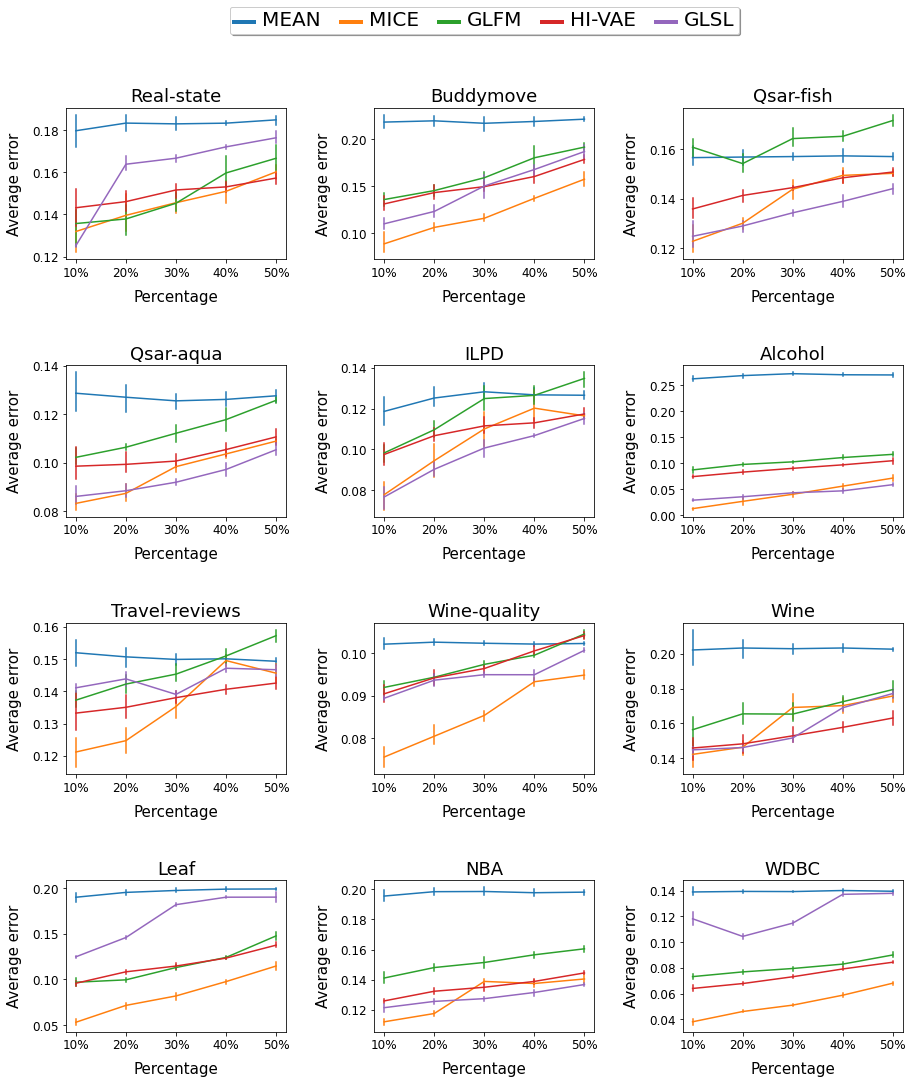

In [19]:
import pandas as pd
import json
import statistics as stats
from os import listdir
import numpy as np

methods = [
    "MEAN", 
    "MICE", 
    "GLFM", 
    "HIVAE", 
    "VBSEM",
    "glsl_EMPTY"
]

renamed_methods = [
    "MEAN", 
    "MICE", 
    "GLFM", 
    "HI-VAE", 
    "GLSL"
]

max_percentage = 6
n_runs = 5
directory ="../../missing_results/continuous/"
data_names = [
        "real_state_valuation", 
        "buddymove", 
        "qsar_fish_toxicity", 
        "qsar_aqua_toxicity", 
        "ilpd",
        "alcohol",
        "travel_reviews",
        "wine_quality_white", 
        "wine", 
        "leaf", 
        "nba", 
        "wdbc",
]

data_names_fancy = ["Real-state", "Buddymove", "Qsar-fish", "Qsar-aqua", "ILPD", "Alcohol", "Travel-reviews",
                   "Wine-quality", "Wine", "Leaf", "NBA", "WDBC"]



row_count = 0 # Counts for plotting (row axis)
col_count = 0 # Counts for plotting (col axis)

from matplotlib import pyplot as plt
import seaborn as sns

fig, axs = plt.subplots(4, 3, figsize=(15,17))

for d in range(0, len(data_names)):
    data_name=data_names[d]
    
    error_dfs = [] # One for each percentage
        
    for p in range(1, max_percentage):
        miss_percentage_string = "0" + str(p)
        df_error_results = pd.DataFrame(columns=methods)
        
        for i in range(1, n_runs + 1):

            error_results = {"run": i}
        
            for method_name in methods:
                json_name = data_name + "_" + miss_percentage_string + "_results_" + method_name + ".json"
                full_path = directory + data_name + "/" + json_name
                with open(full_path) as json_file:
                    json_data = json.load(json_file)
                    runs_data = json_data["runs"]
                    errors = []
                    learning_times = []

                    if directory == "../../missing_results/discrete/":
                        error_results[method_name] = 1.0 - runs_data["run_" + str(i)]["accuracy"]
                    elif directory == "../../missing_results/continuous/":
                        error_results[method_name] = runs_data["run_" + str(i)]["nrmse"]
                    else:
                        error_results[method_name] = runs_data["run_" + str(i)]["average_error"]

            df_error_results = df_error_results.append(error_results, ignore_index=True)

        error_dfs.append(df_error_results)
        
    for i in range(0, max_percentage-1):
        error_dfs[i]["GLSL"] = error_dfs[i][['VBSEM','glsl_EMPTY']].min(axis=1)
    
    # Rename columns
    for i in range(0, max_percentage-1):
        error_dfs[i] = error_dfs[i].rename(columns={"HIVAE": "HI-VAE"})
    
    ############################################################################
    # Prepare DF for plotting
    ############################################################################
    df_plot = pd.DataFrame(columns=["dataset", "method", "percentage", "AvgErr"])

    for percentage in range(0, 5):
        df = error_dfs[percentage]
        percentage_string = str((percentage+1)*10) + "%"
        for method in renamed_methods:
            for i in range(len(df)):
                row = df.loc[i]
                instance = {"run": row["run"]}
                instance["percentage"] = percentage_string
                instance["method"] = method
                instance["AvgErr"] = row[method]
                df_plot = df_plot.append(instance, ignore_index=True)
                
    ############################################################################
    # Plotting
    ############################################################################
    g = sns.lineplot(data=df_plot,x="percentage", y="AvgErr", hue="method", err_style="bars", ax = axs[row_count, col_count], legend=False)
    axs[row_count, col_count].set_title(data_names_fancy[d], fontsize=18)
    axs[row_count, col_count].set_ylabel("Average error", fontsize=15, labelpad=10)
    axs[row_count, col_count].set_xlabel("Percentage", fontsize=15, labelpad=10)
    axs[row_count, col_count].tick_params(axis="x", labelsize=12) # x ticks font size
    axs[row_count, col_count].tick_params(axis="y", labelsize=12) # x ticks font size
       
    #### Update row/column index of the axis plot
    col_count = col_count + 1
    if col_count == 3:
        col_count = 0
        row_count = row_count + 1
    
    #############################################################################
    # Final adjustments to the plot

axs[0,1].legend(loc='upper center', bbox_to_anchor=(0.5, 1.70),  fancybox=True, shadow=True, ncol=5, labels=['MEAN', 'MICE', 'GLFM', 'HI-VAE', 'GLSL'])
plt.setp(axs[0,1].get_legend().get_texts(), fontsize='20') # for legend text
plt.setp(axs[0,1].get_legend().get_title(), fontsize='0') # for legend title
for line in axs[0,1].get_legend().get_lines():
    line.set_linewidth(4.0)

fig.subplots_adjust(hspace=0.7)
fig.subplots_adjust(wspace=0.4)

plt.savefig('missing_plots/continuous_errors.pdf')  

## 2.2 - Execution times

In [20]:
import pandas as pd
import json
import statistics as stats
from os import listdir
import numpy as np
from math import nan

methods = [
    "MEAN", 
    "MICE", 
    "GLFM", 
    "HIVAE",  
    "glsl_EMPTY"
          ]
max_percentage = 6
n_runs = 5
directories = ["../../missing_results/continuous/"]
accuracy_error_dfs = []
data_names = [
        "real_state_valuation", 
        "buddymove", 
        "qsar_fish_toxicity", 
        "qsar_aqua_toxicity", 
        "ilpd",
        "alcohol",
        "travel_reviews",
        "wine_quality_white", 
        "wine", 
        "leaf", 
        "nba", 
        "wdbc",
        "waveform", 
        "100_plants", 
        "geo_music"
]

df_avg_time_results = pd.DataFrame(columns=methods)
df_stdev_time_results = pd.DataFrame(columns=methods)

for directory in directories:       
    for data_name in data_names:
        # Creamos 2 diccionarios con los valores medios y sd de cada metodo
        avg_time_results = {"dataset": data_name}
        stdev_time_results = {"dataset": data_name}       
        for method_name in methods:
            learning_times = []
        
            for i in range(1, max_percentage):
                miss_percentage_string = "0" + str(i)
                json_name = data_name + "_" + miss_percentage_string + "_results_" + method_name + ".json"
                full_path = directory + data_name + "/" + json_name
                try:
                    with open(full_path) as json_file:
                        json_data = json.load(json_file)
                        runs_data = json_data["runs"]
                        for j in range(1, n_runs + 1):  
                            learning_times.append(runs_data["run_" + str(j)]["learning_time"]/1000)
                except:
                    learning_times.append(nan)
            avg_learning_time = stats.mean(learning_times)
            avg_time_results[method_name] = avg_learning_time
            stdev_learning_time = stats.stdev(learning_times)
            stdev_time_results[method_name] = stdev_learning_time
        
        df_avg_time_results = df_avg_time_results.append(avg_time_results, ignore_index=True)
        df_stdev_time_results = df_stdev_time_results.append(stdev_time_results, ignore_index=True)
        
df_avg_time_results

,MEAN,MICE,GLFM,HIVAE,glsl_EMPTY,dataset
0,0.00040,0.044221,15.571654,59.554231,1651.04740,real_state_valuation
1,0.00072,0.068257,14.140395,69.398144,518.41612,buddymove
2,0.00084,0.088249,73.211309,90.794089,3245.26072,qsar_fish_toxicity
3,0.00100,0.102924,70.448298,103.168277,6483.70224,qsar_aqua_toxicity
4,0.00268,0.138749,99.030820,184.029686,11009.09324,ilpd
5,0.00736,0.113750,16.466790,186.324675,1064.19984,alcohol
6,0.00100,0.145347,156.853228,115.992997,14084.96040,travel_reviews
7,0.00556,0.541267,1158.774478,369.924772,722189.03684,wine_quality_white
8,0.00144,0.156250,44.860019,144.380717,4867.44880,wine
9,0.00112,0.182524,100.784128,144.202546,8211.78756,leaf


In [21]:
for i in range(0,12):
    string_to_show = ""
    print(df_avg_time_results.iloc[i,4])
    for j in range(0,4):
        mean = df_avg_time_results.iloc[i,j]
        stdev = df_stdev_time_results.iloc[i,j]
        if j == 3:
            sep = " \\\\"
        else:
            sep = " & "
        string_to_show = string_to_show + str("%0.2f" % mean) + " & " + "(" + str("%0.2f" % stdev)+ ")" + sep
    print(string_to_show)

1651.0474
0.00 & (0.00) & 0.04 & (0.01) & 15.57 & (0.29) & 59.55 & (2.36) \\
518.41612
0.00 & (0.00) & 0.07 & (0.01) & 14.14 & (0.40) & 69.40 & (5.79) \\
3245.26072
0.00 & (0.00) & 0.09 & (0.01) & 73.21 & (3.87) & 90.79 & (13.79) \\
6483.70224
0.00 & (0.00) & 0.10 & (0.03) & 70.45 & (0.99) & 103.17 & (5.45) \\
11009.09324
0.00 & (0.00) & 0.14 & (0.02) & 99.03 & (4.97) & 184.03 & (7.25) \\
1064.19984
0.01 & (0.03) & 0.11 & (0.04) & 16.47 & (1.90) & 186.32 & (7.89) \\
14084.9604
0.00 & (0.00) & 0.15 & (0.02) & 156.85 & (0.88) & 115.99 & (2.86) \\
722189.03684
0.01 & (0.00) & 0.54 & (0.09) & 1158.77 & (8.64) & 369.92 & (18.55) \\
4867.4488
0.00 & (0.00) & 0.16 & (0.07) & 44.86 & (7.26) & 144.38 & (42.75) \\
8211.78756
0.00 & (0.00) & 0.18 & (0.06) & 100.78 & (7.44) & 144.20 & (10.08) \\
81962.45264
0.00 & (0.00) & 0.23 & (0.14) & 343.20 & (92.55) & 259.49 & (89.40) \\
359282.92468
0.00 & (0.01) & 0.61 & (0.29) & 1053.38 & (94.75) & 295.10 & (77.39) \\


# 3 - Mixed

## 3.1 - All error plots

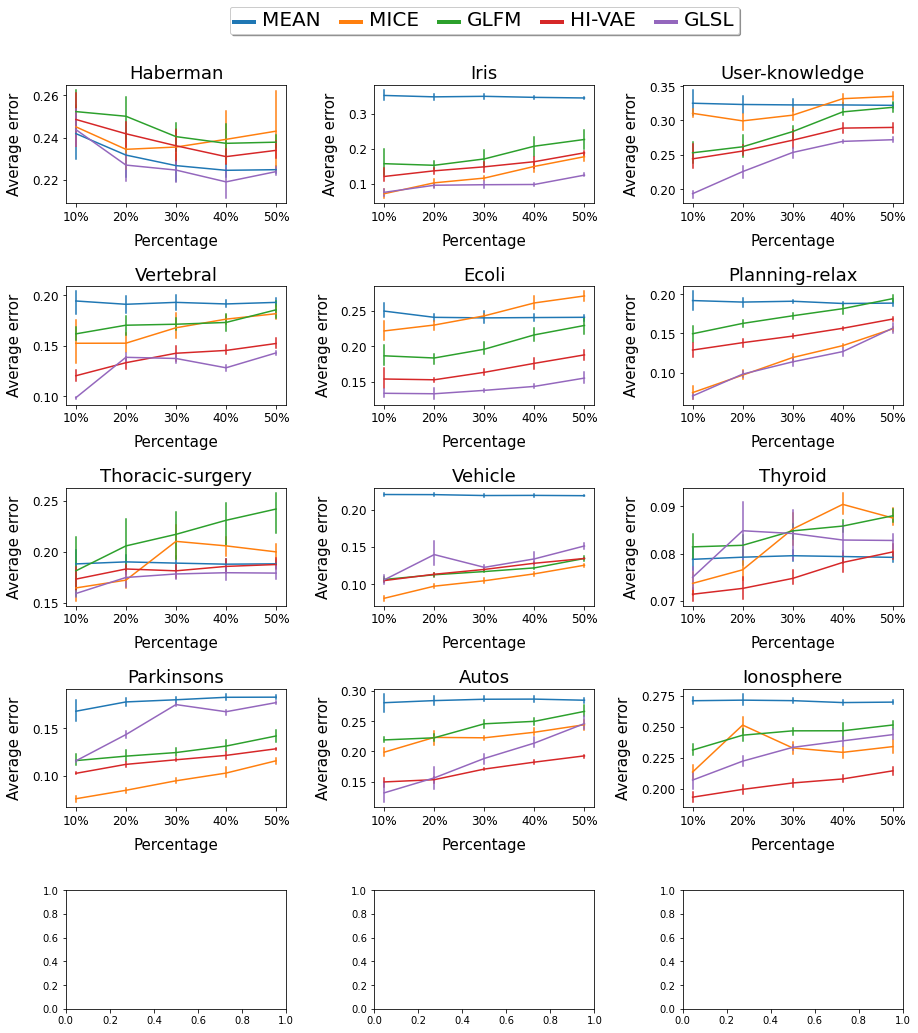

In [23]:
import pandas as pd
import json
import statistics as stats
from os import listdir
import numpy as np

methods = [
    "MEAN", 
    "MICE", 
    "GLFM", 
    "HIVAE", 
    "VBSEM",
    "glsl_EMPTY"
]

renamed_methods = [
    "MEAN", 
    "MICE", 
    "GLFM", 
    "HI-VAE", 
    "GLSL"
]

max_percentage = 6
n_runs = 5
directory = "../../missing_results/mixed/"
data_names = [
        "haberman", 
        "iris", 
        "user_knowledge",
        "vertebral", 
        "ecoli", 
        "planning_relax", 
        "thoracic_surgery",
        "vehicle", 
        "thyroid",
        "parkinsons", 
        "autos", 
        "ionosphere"
]

data_names_fancy = ["Haberman", "Iris", "User-knowledge", "Vertebral", "Ecoli", "Planning-relax", "Thoracic-surgery",
                   "Vehicle", "Thyroid", "Parkinsons", "Autos", "Ionosphere"]



row_count = 0 # Counts for plotting (row axis)
col_count = 0 # Counts for plotting (col axis)

from matplotlib import pyplot as plt
import seaborn as sns

fig, axs = plt.subplots(5, 3, figsize=(15,17))

for d in range(0, len(data_names)):
    data_name=data_names[d]
    
    error_dfs = [] # One for each percentage
        
    for p in range(1, max_percentage):
        miss_percentage_string = "0" + str(p)
        df_error_results = pd.DataFrame(columns=methods)
        
        for i in range(1, n_runs + 1):

            error_results = {"run": i}
        
                
            for method_name in methods:
                json_name = data_name + "_" + miss_percentage_string + "_results_" + method_name + ".json"
                full_path = directory + data_name + "/" + json_name
                with open(full_path) as json_file:
                    json_data = json.load(json_file)
                    runs_data = json_data["runs"]
                    errors = []
                    learning_times = []

                    if directory == "../../missing_results/discrete/":
                        error_results[method_name] = 1.0 - runs_data["run_" + str(i)]["accuracy"]
                    elif directory == "../../missing_results/continuous/":
                        error_results[method_name] = runs_data["run_" + str(i)]["nrmse"]
                    else:
                        error_results[method_name] = runs_data["run_" + str(i)]["average_error"]

            df_error_results = df_error_results.append(error_results, ignore_index=True)

        error_dfs.append(df_error_results)
    
    for i in range(0, max_percentage-1):
        error_dfs[i]["GLSL"] = error_dfs[i][['VBSEM','glsl_EMPTY']].min(axis=1)
    
    # Rename columns
    for i in range(0, max_percentage-1):
        error_dfs[i] = error_dfs[i].rename(columns={"HIVAE": "HI-VAE"})
    
    ############################################################################
    # Prepare DF for plotting
    ############################################################################
    df_plot = pd.DataFrame(columns=["dataset", "method", "percentage", "AvgErr"])

    for percentage in range(0, 5):
        df = error_dfs[percentage]
        percentage_string = str((percentage+1)*10) + "%"
        for method in renamed_methods:
            for i in range(len(df)):
                row = df.loc[i]
                instance = {"run": row["run"]}
                instance["percentage"] = percentage_string
                instance["method"] = method
                instance["AvgErr"] = row[method]
                df_plot = df_plot.append(instance, ignore_index=True)
                
    ############################################################################
    # Plotting
    ############################################################################
    
#     print(str(row_count) + "," + str(col_count))
    g = sns.lineplot(data=df_plot,x="percentage", y="AvgErr", hue="method", err_style="bars", ax = axs[row_count, col_count], legend=False)
    axs[row_count, col_count].set_title(data_names_fancy[d], fontsize=18)
    axs[row_count, col_count].set_ylabel("Average error", fontsize=15, labelpad=10)
    axs[row_count, col_count].set_xlabel("Percentage", fontsize=15, labelpad=10)
    axs[row_count, col_count].tick_params(axis="x", labelsize=12) # x ticks font size
    axs[row_count, col_count].tick_params(axis="y", labelsize=12) # x ticks font size
       
    #### Update row/column index of the axis plot
    col_count = col_count + 1
    if col_count == 3:
        col_count = 0
        row_count = row_count + 1
    
    #############################################################################
    # Final adjustments to the plot

axs[0,1].legend(loc='upper center', bbox_to_anchor=(0.5, 1.70),  fancybox=True, shadow=True, ncol=5, labels=['MEAN', 'MICE', 'GLFM', 'HI-VAE', 'GLSL'])
plt.setp(axs[0,1].get_legend().get_texts(), fontsize='20') # for legend text
plt.setp(axs[0,1].get_legend().get_title(), fontsize='0') # for legend title
for line in axs[0,1].get_legend().get_lines():
    line.set_linewidth(4.0)

fig.subplots_adjust(hspace=0.7)
fig.subplots_adjust(wspace=0.4)

plt.savefig('missing_plots/mixed_errors.pdf')  

## 3.2 - Execution times

In [24]:
import pandas as pd
import json
import statistics as stats
from os import listdir
import numpy as np
from math import nan

methods = [
#     "MEAN", 
    "MICE", 
    "GLFM", 
    "HIVAE",  
    "glsl_EMPTY"
          ]
max_percentage = 6
n_runs = 5
directories = ["../../missing_results/mixed/"]
accuracy_error_dfs = []
data_names = [
        "haberman", 
        "iris", 
        "user_knowledge",
        "vertebral", 
        "ecoli", 
        "planning_relax", 
        "thoracic_surgery",
        "vehicle", 
        "thyroid",
        "parkinsons", 
        "autos", 
        "ionosphere",
        "new_qsar_biodeg",
        "housing_prices",
        "census_india"
]

df_avg_time_results = pd.DataFrame(columns=methods)
df_stdev_time_results = pd.DataFrame(columns=methods)

for directory in directories:       
    for data_name in data_names:
        # Creamos 2 diccionarios con los valores medios y sd de cada metodo
        avg_time_results = {"dataset": data_name}
        stdev_time_results = {"dataset": data_name}       
        for method_name in methods:
            learning_times = []
        
            for i in range(1, max_percentage):
                miss_percentage_string = "0" + str(i)
                json_name = data_name + "_" + miss_percentage_string + "_results_" + method_name + ".json"
                full_path = directory + data_name + "/" + json_name
                try:
                    with open(full_path) as json_file:
                        json_data = json.load(json_file)
                        runs_data = json_data["runs"]
                        for j in range(1, n_runs + 1):  
                            learning_times.append(runs_data["run_" + str(j)]["learning_time"]/1000)
                except:
                    learning_times.append(nan)
            avg_learning_time = stats.mean(learning_times)
            avg_time_results[method_name] = avg_learning_time
            stdev_learning_time = stats.stdev(learning_times)
            stdev_time_results[method_name] = stdev_learning_time
        
        df_avg_time_results = df_avg_time_results.append(avg_time_results, ignore_index=True)
        df_stdev_time_results = df_stdev_time_results.append(stdev_time_results, ignore_index=True)
        
df_avg_time_results
# df_stdev_time_results

,MICE,GLFM,HIVAE,glsl_EMPTY,dataset
0,0.028133,8.474717,45.353637,34.94292,haberman
1,0.055743,8.647240,49.409340,114.92236,iris
2,0.071361,19.573078,73.281336,86.26540,user_knowledge
3,0.076163,38.314827,74.094252,804.43860,vertebral
4,0.085096,31.869875,70.966427,1997.55776,ecoli
5,0.150431,54.414113,108.184639,888.81436,planning_relax
6,0.165648,139.673912,171.178160,4060.88940,thoracic_surgery
7,0.253028,562.695525,302.297035,310741.70240,vehicle
8,0.569614,2722.984205,520.565361,654996.82216,thyroid
9,0.368995,134.346720,193.929965,47831.02568,parkinsons


In [25]:
for i in range(0,12):
    string_to_show = ""
    print(df_avg_time_results.iloc[i,4])
    for j in range(0,4):
        mean = df_avg_time_results.iloc[i,j]
        stdev = df_stdev_time_results.iloc[i,j]
        if j == 3:
            sep = " \\\\"
        else:
            sep = " & "
        string_to_show = string_to_show + str("%0.2f" % mean) + " & " + "(" + str("%0.2f" % stdev)+ ")" + sep
    print(string_to_show)

haberman
0.03 & (0.01) & 8.47 & (0.16) & 45.35 & (9.80) & 34.94 & (16.02) \\
iris
0.06 & (0.00) & 8.65 & (0.67) & 49.41 & (7.27) & 114.92 & (47.38) \\
user_knowledge
0.07 & (0.01) & 19.57 & (0.38) & 73.28 & (4.00) & 86.27 & (14.10) \\
vertebral
0.08 & (0.02) & 38.31 & (2.03) & 74.09 & (22.83) & 804.44 & (380.33) \\
ecoli
0.09 & (0.01) & 31.87 & (1.37) & 70.97 & (16.28) & 1997.56 & (1252.17) \\
planning_relax
0.15 & (0.04) & 54.41 & (13.55) & 108.18 & (17.92) & 888.81 & (436.57) \\
thoracic_surgery
0.17 & (0.06) & 139.67 & (6.72) & 171.18 & (11.85) & 4060.89 & (1679.43) \\
vehicle
0.25 & (0.10) & 562.70 & (34.00) & 302.30 & (27.32) & 310741.70 & (208581.18) \\
thyroid
0.57 & (0.25) & 2722.98 & (173.77) & 520.57 & (10.99) & 654996.82 & (482907.46) \\
parkinsons
0.37 & (0.08) & 134.35 & (11.78) & 193.93 & (26.80) & 47831.03 & (38792.18) \\
autos
0.34 & (0.12) & 151.87 & (63.79) & 176.70 & (35.57) & 288169.36 & (268149.54) \\
ionosphere
0.66 & (0.13) & 470.76 & (92.36) & 400.10 & (22.51) &